# Matching Market

This simple model consists of a buyer, a supplier, and a market. 

The buyer represents a group of customers whose willingness to pay for a single unit of the good is captured by a vector of prices _wta_. You can initiate the buyer with a set_quantity function which randomly assigns the willingness to pay according to your specifications. You may ask for these willingness to pay quantities with a _getbid_ function. 

The supplier is similar, but instead the supplier is willing to be paid to sell a unit of technology. The supplier for instance may have non-zero variable costs that make them unwilling to produce the good unless they receive a specified price. Similarly the supplier has a  get_ask function which returns a list of desired prices. 

The willingness to pay or sell are set randomly using uniform random distributions. The resultant lists of bids are effectively a demand curve. Likewise the list of asks is effectively a supply curve. A more complex determination of bids and asks is possible, for instance using time of year to vary the quantities being demanded. 

## New in version 18
- buyers should always consume, fixed by adding storage on which they can 'bank' the rational of the above is not the mimic strategic storage behavior but to address the reality that natural gas for household heating subtracted from the city-level distribution net is always delivered even if not directly paid for.
- added unproven reserves for paces scenario

## Microeconomic Foundations

The market assumes the presence of an auctioneer which will create a _book_, which seeks to match the bids and the asks as much as possible. If the auctioneer is neutral, then it is incentive compatible for the buyer and the supplier to truthfully announce their bids and asks. The auctioneer will find a single price which clears as much of the market as possible. Clearing the market means that as many willing swaps happens as possible. You may ask the market object at what price the market clears with the get_clearing_price function. You may also ask the market how many units were exchanged with the get_units_cleared function.

## Agent-Based Objects

The following section presents three objects which can be used to make an agent-based model of an efficient, two-sided market.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import random as rnd
import pandas as pd
import numpy as np
import time
import datetime
import calendar
import json
import statistics

# fix what is missing with the datetime/time/calendar package
def add_months(sourcedate,months):
    month = sourcedate.month - 1 + months
    year = int(sourcedate.year + month / 12 )
    month = month % 12 + 1
    day = min(sourcedate.day,calendar.monthrange(year, month)[1])
    return datetime.date(year,month,day)

# measure how long it takes to run the script
startit = time.time()
dtstartit = datetime.datetime.now()

## classes buyers and sellers
Below we are constructing the buyers and sellers in classes.

In [2]:
class Seller():
    def __init__(self, name):
        self.name = name
        self.wta = []
        self.step = 0
        self.prod = 2000
        self.lb_price = 10
        self.lb_multiplier = 0
        self.ub_price = 20
        self.ub_multiplier = 0
        self.init_reserve = 500000
        self.reserve = 500000
        self.init_unproven_reserve = 0
        self.unproven_reserve = 0
        #multiple market idea, also 'go away from market'
        self.subscr_market = {}
        self.last_price = 15
        self.state_hist = {}
        self.cur_scenario = ''
        self.count = 0
        self.storage = 0
        self.q_to_market = 0
        self.ratio_sold = 0
        self.ratio_sold_hist = []

    # the supplier has n quantities that they can sell
    # they may be willing to sell this quantity anywhere from a lower price of l
    # to a higher price of u
    def set_quantity(self):
        self.count = 0
        self.update_price()
        n = self.prod
        l = self.lb_price + self.lb_multiplier
        u = self.ub_price + self.ub_multiplier
        wta = []
        for i in range(n):
            p = rnd.uniform(l, u)
            wta.append(p)
        if len(wta) < self.reserve:
            self.wta = wta
        else:
            self.wta = wta[0:(self.reserve-1)]
            self.prod = self.reserve
        if len(self.wta) > 0:
            self.wta = self.wta #sorted(self.wta, reverse=False)
        self.q_to_market = len(self.wta)
        
        
    def get_name(self):
        return self.name

    def get_asks(self):
        return self.wta

    def extract(self, cur_extraction):
        if self.reserve > 0:
            self.reserve = self.reserve - cur_extraction
        else:
            self.prod = 0

    # production costs rise a 100% 
    def update_price(self):
        depletion = (self.init_reserve - self.reserve) / self.init_reserve
        self.ub_multiplier = int(self.ub_price * depletion)
        self.lb_multiplier = int(self.lb_price * depletion)
        
    def return_not_cleared(self, not_cleared):
        self.count = self.count + (len(self.wta) - len(not_cleared))
        self.wta = not_cleared

    def get_price(self, price):
        self.last_price = price
        
    # update production if 90% of the bids is sold
    def update_production(self):
        if (self.step/12).is_integer():
            if self.prod > 0 and self.q_to_market > 0:
                rp_ratio = self.reserve / self.prod
                self.ratio_sold = self.count / self.q_to_market
                self.ratio_sold_hist.append(self.ratio_sold)
                yearly_average = statistics.mean(self.ratio_sold_hist[-12:])
                if (rp_ratio > 15) and (yearly_average > .9):
                    print("%s evaluate production" % self.name)
                    self.prod = int(self.prod * 1.1)
                if (self.unproven_reserve > 0) and (self.cur_scenario == 'PACES'):
                    self.reserve = self.reserve + int(0.1 * self.init_unproven_reserve)
                    self.unproven_reserve = self.unproven_reserve - int(0.1 * self.init_unproven_reserve)
                    
    def evaluate_timestep(self):
        self.update_production()

    # record every step into an dictionary, nog pythonic look into (vars)
    def book_keeping(self):
        self.state_hist[self.step] = self.__dict__

        
class Buyer():
    def __init__(self, name):
        self.name = name
        self.type = 0
        self.rof = 0
        self.wtp = []
        self.step = 0
        self.offset= 0
        self.base_demand = 0
        self.max_demand = 0
        self.lb_price = 10
        self.ub_price = 20
        self.last_price = 15
        self.subscr_market = {}
        self.state_hist = {}
        self.cur_scenario = ''
        self.count = 0
        self.real_demand = 0
        self.storage_cap = 1
        self.storage = 0
        self.storage_q = 0

    # the supplier has n quantities that they can buy
    # they may be willing to sell this quantity anywhere from a lower price of l
    # to a higher price of u
    def set_quantity(self):
        self.count = 0
        self.update_price()
        n = int(self.consumption(self.step))
        l = self.lb_price
        u = self.ub_price
        wtp = []
        for i in range(n):
            p = rnd.uniform(l, u)
            wtp.append(p)
        self.wtp = wtp #sorted(wtp, reverse=True)
        
    # gets a little to obvious
    def get_name(self):
        return self.name
    
    # return list of willingness to pay
    def get_bids(self):
        return self.wtp
    
    def consumption(self, x):
        # make it initialise to seller
        b = self.base_demand
        m = self.max_demand
        y = b + m * (.5 * (1 + np.cos(((x+self.offset)/6)*np.pi)))
        self.real_demand = y
        s = self.storage_manager()
        return(y+s)
    
    def update_price(self):
        # adjust Q
        if self.type == 1: #home
            if (self.step/12).is_integer():
                self.base_demand = home_savings[self.cur_scenario] * self.base_demand
                self.max_demand = home_savings[self.cur_scenario] * self.max_demand
        if self.type == 2: # elec for eu + us
            if (self.step/12).is_integer():
                cur_elec_df = elec_space['RELATIVE'][self.cur_scenario]
                period_now = add_months(period_null, self.step)
                index_year = int(period_now.strftime('%Y'))
                #change_in_demand = cur_elec_df[index_year]
                self.base_demand = self.base_demand * cur_elec_df[index_year]
                self.max_demand = self.max_demand * cur_elec_df[index_year]
        if self.type == 3: #indu
            if (self.step/12).is_integer():
                if (self.rof == 0) and (self.cur_scenario == 'PACES'):
                    #cur_df = economic_growth['ECONOMIC GROWTH'][self.cur_scenario]
                    period_now = add_months(period_null, self.step)
                    index_year = int(period_now.strftime('%Y'))
                    #growth = cur_df[index_year]
                    growth = np.arctan((index_year-2013)/10)/(.5*np.pi)*.05+0.03
                    self.base_demand = (1 + growth) * self.base_demand
                    self.max_demand = (1 + growth) * self.max_demand
                else:
                    cur_df = economic_growth['ECONOMIC GROWTH'][self.cur_scenario]
                    period_now = add_months(period_null, self.step)
                    index_year = int(period_now.strftime('%Y'))
                    growth = cur_df[index_year]
                    self.base_demand = (1 + growth) * self.base_demand
                    self.max_demand = (1 + growth) * self.max_demand
                    
        ## adjust P now to get_price, but adress later
        ## moved to get_price, rename update_price function (?)
        #self.lb_price = self.last_price * .75
        #self.ub_price= self.last_price * 1.25

    def return_not_cleared(self, not_cleared):
        self.count = self.count + (len(self.wtp)-len(not_cleared))
        self.wtp = not_cleared

    def get_price(self, price):
        self.last_price = price
        if self.last_price > 100:
            self.last_price = 100
        self.lb_price = self.last_price * .75
        self.ub_price= self.last_price * 1.25
    
    # writes complete state to a dictionary, see if usefull
    def book_keeping(self):
        self.state_hist[self.step] = self.__dict__
        
    # there has to be some accountability for uncleared bids of the buyers
    # here substract bids from storage which are not cleared (even if storage is empty)
    # function storage_manager() will fill up the storage
    def evaluate_timestep(self):
        if self.type==1 or self.type==3:
            not_cleared = len(self.wtp)
            #total_demand = self.real_demand + self.storage_q
            storage_delta = self.storage_q - not_cleared
            self.storage = self.storage + storage_delta

    def storage_manager(self):
        # check if buyer is household buyer
        # buys back 10% more to anticipate not clearing everything and building a little storage
        if self.type==1 or self.type==3:
            if self.storage < 0:
                self.storage_q = -self.storage * 1.1
            else:
                self.storage_q = 0
            return(self.storage_q)
        else:
            return(0)


## Construct the market
For the market two classes are made. The market itself, which controls the buyers and the sellers, and the book. The market has a book where the results of the clearing procedure are stored.

In [3]:
# the book is an object of the market used for the clearing procedure
class Book():
    def __init__(self):
        self.ledger = pd.DataFrame(columns = ("role","name","price","cleared"))

    def set_asks(self,seller_list):
        # ask each seller their name
        # ask each seller their willingness
        # for each willingness append the data frame
        for seller in seller_list:
            seller_name = seller.get_name()
            seller_price = seller.get_asks()
            #seller_df = [['seller' for i in seller_price],
            #              [seller_name for i in seller_price],
            #              seller_price,
            #              ['in process' for i in seller_price]]
            #seller_df = np.array(seller_df).T
            ar_role = np.full((1,len(seller_price)),'seller')
            ar_name = np.full((1,len(seller_price)),seller_name)
            ar_cleared = np.full((1,len(seller_price)),'in process')
            temp_ledger = pd.DataFrame([*ar_role,*ar_name,seller_price,*ar_cleared]).T
            temp_ledger.columns= ["role","name","price","cleared"]
            #temp_ledger = pd.DataFrame(seller_df, columns= ["role","name","price","cleared"])
            self.ledger = self.ledger.append(temp_ledger, ignore_index=True)

    def set_bids(self,buyer_list):
        # ask each seller their name
        # ask each seller their willingness
        # for each willingness append the data frame
        for buyer in buyer_list:
            buyer_name = buyer.get_name()
            buyer_price = buyer.get_bids()
            #buyer_df = []
            #for i in buyer_price:
            #    buyer_df.append(['buyer',buyer_name,i,'in process'])
            ar_role = np.full((1,len(buyer_price)),'buyer')
            ar_name = np.full((1,len(buyer_price)),buyer_name)
            ar_cleared = np.full((1,len(buyer_price)),'in process')
            temp_ledger = pd.DataFrame([*ar_role,*ar_name,buyer_price,*ar_cleared]).T
            temp_ledger.columns= ["role","name","price","cleared"]
            #temp_ledger = pd.DataFrame(buyer_df, columns= ["role","name","price","cleared"])
            self.ledger = self.ledger.append(temp_ledger, ignore_index=True)
            
    def update_ledger(self,ledger):
        self.ledger = ledger
        
    def get_ledger(self):
        return self.ledger
    
    def clean_ledger(self):
        self.ledger = pd.DataFrame(columns = ("role","name","price","cleared"))

class Market():
    def __init__(self, name):
        self.name= name
        self.count = 0
        self.last_price = ''
        self.book = Book()
        self.b = []
        self.s = []
        self.buyer_list = []
        self.seller_list = []
        self.buyer_dict = {}
        self.seller_dict = {}
        self.ledger = ''

    # move to observer
    # not called
    def update_seller(self):
        for i in self.seller_dict:
            self.seller_dict[i].step += 1
            self.seller_dict[i].set_quantity()
    
    # not called
    def update_buyer(self):
        for i in self.buyer_dict:
            self.buyer_dict[i].step += 1
            self.buyer_dict[i].set_quantity()
            
    def book_keeping_all(self):
        for i in self.buyer_dict:
            self.buyer_dict[i].book_keeping()
        for i in self.seller_dict:
            self.seller_dict[i].book_keeping()
    
    def add_buyer(self,buyer):
        if buyer.subscr_market[self.name] == 1:
            self.buyer_list.append(buyer)
        
    def add_seller(self,seller):
        if seller.subscr_market[self.name] == 1:       
            self.seller_list.append(seller)
        
    def set_book(self):
        self.book.set_bids(self.buyer_list)
        self.book.set_asks(self.seller_list)
    
    #def get_ledger(self):
    #    self.ledger = self.book.get_ledger()
    #    return self.ledger
    
    def get_bids(self):
        # this is a data frame
        ledger = self.book.get_ledger()
        rows= ledger.loc[ledger['role'] == 'buyer']
        # this is a series
        prices=rows['price']
        # this is a list
        bids = prices.tolist()
        return bids
    
    def get_asks(self):
        # this is a data frame
        ledger = self.book.get_ledger()
        rows = ledger.loc[ledger['role'] == 'seller']
        # this is a series
        prices=rows['price']
        # this is a list
        asks = prices.tolist()
        return asks
    
    # return the price at which the market clears
    # this fails because there are more buyers then sellers
    
    def get_clearing_price(self):
        # buyer makes a bid starting with the buyer which wants it most
        b = self.get_bids()
        s = self.get_asks()
        # highest to lowest
        self.b=sorted(b, reverse=True)
        # lowest to highest
        self.s=sorted(s, reverse=False)
        
        # find out whether there are more buyers or sellers
        # then drop the excess buyers or sellers; they won't compete
        n = len(b)
        m = len(s)
        
        # there are more sellers than buyers
        # drop off the highest priced sellers 
        if (m > n):
            s = s[0:n]
            matcher = n
        # There are more buyers than sellers
        # drop off the lowest bidding buyers 
        else:
            b = b[0:m]
            matcher = m
        
        # It's possible that not all items sold actually clear the market here
        # Produces an error when one of the two lists are empty
        # something like 'can't compare string and float'
        count = 0
        for i in range(matcher):
            if (self.b[i] > self.s[i]):
                count +=1
                self.last_price = self.b[i]
        
        # copy count to market object
        self.count = count
        return self.last_price
    
    # TODO: Annotate the ledger
    # this procedure takes up 80% of processing time
    def annotate_ledger(self,clearing_price):
        ledger = self.book.get_ledger()
        for index, row in ledger.iterrows():
            if (row['role'] == 'seller'):
                if (row['price'] < clearing_price):
                    ledger.loc[index,'cleared'] = 'True'
                else:
                    ledger.loc[index,'cleared'] = 'False'
            else:
                if (row['price'] > clearing_price):
                    ledger.loc[index,'cleared'] = 'True'
                else:
                    ledger.loc[index,'cleared'] = 'False'  
                    
        self.book.update_ledger(ledger)
    
    def get_units_cleared(self):
        return self.count
    
    def clean_ledger(self):
        self.ledger = ''
        self.book.clean_ledger()

    def run_it(self):
        self.pre_clearing_operation()
        self.clearing_operation()
        self.after_clearing_operation()
        
        # pre clearing empty out the last run and start
        # clean ledger is kind of sloppy, rewrite functions to overide the ledger
    def pre_clearing_operation(self):
        self.clean_ledger()
        
    def clearing_operation(self):
        self.set_book()
        clearing_price = self.get_clearing_price()
        print(self.name, clearing_price)
        #start_clearing = datetime.datetime.now()
        self.annotate_ledger(clearing_price)
        #print(datetime.datetime.now() - start_clearing)
        
    def after_clearing_operation(self):
        for agent in self.seller_list:
            name = agent.name
            cur_extract = len(self.book.ledger[(self.book.ledger['cleared'] == 'True') &
                              (self.book.ledger['name'] == name)])
            agent.extract(cur_extract)
            agent.get_price(self.last_price)
            if cur_extract >0:
                agent_asks = agent.get_asks()
                agent_asks = sorted(agent_asks, reverse=False)
                not_cleared = agent_asks[cur_extract:len(agent_asks)]
                agent.return_not_cleared(not_cleared)

        for agent in self.buyer_list:
            name = agent.name
            cur_extract = len(self.book.ledger[(self.book.ledger['cleared'] == 'True') &
                              (self.book.ledger['name'] == name)])
            agent.get_price(self.last_price)
            if cur_extract >0:
                agent_bids = agent.get_bids()
                agent_bids = sorted(agent_bids, reverse=True)
                not_cleared = agent_bids[cur_extract:len(agent_bids)]
                agent.return_not_cleared(not_cleared)
            #print(name,cur_extract)

        # cleaning up the books
        self.book_keeping_all()


## Observer
The observer holds the clock and collects data. In this setup it tells the market another tick has past and it is time to act. The market will instruct the other agents. The observer initializes the model, thereby making real objects out of the classes defined above.

In [4]:
class Observer():
    def __init__(self, init_buyer, init_seller, timesteps, scenario):
        self.init_buyer = init_buyer
        self.init_seller = init_seller
        self.init_market = init_market
        self.maxrun = timesteps
        self.cur_scenario = scenario
        self.buyer_dict = {}
        self.seller_dict = {}
        self.market_dict = {}
        self.timetick = 0
        self.gas_market = ''
        self.market_hist = []
        self.seller_hist = []
        self.buyer_hist = []
        self.all_data = {}

    def set_buyer(self, buyer_info):
        for name in buyer_info:
            self.buyer_dict[name] = Buyer('%s' % name)
            self.buyer_dict[name].base_demand = buyer_info[name]['offset']
            self.buyer_dict[name].base_demand = buyer_info[name]['b']
            self.buyer_dict[name].max_demand = buyer_info[name]['m']
            self.buyer_dict[name].lb_price = buyer_info[name]['lb_price']
            self.buyer_dict[name].ub_price = buyer_info[name]['ub_price']
            self.buyer_dict[name].type = buyer_info[name]['type']
            self.buyer_dict[name].rof = buyer_info[name]['rof']
            self.buyer_dict[name].cur_scenario = self.cur_scenario
            self.buyer_dict[name].subscr_market = dict.fromkeys(init_market,0)
            for market in buyer_info[name]['market']:
                self.buyer_dict[name].subscr_market[market] = 1

    def set_seller(self, seller_info):
        for name in seller_info:
            self.seller_dict[name] = Seller('%s' % name)
            self.seller_dict[name].prod = seller_info[name]['prod']
            self.seller_dict[name].lb_price = seller_info[name]['lb_price']
            self.seller_dict[name].ub_price = seller_info[name]['ub_price']
            self.seller_dict[name].reserve = seller_info[name]['reserve']
            self.seller_dict[name].init_reserve = seller_info[name]['reserve']
            self.seller_dict[name].unproven_reserve = seller_info[name]['UP_reserve']
            self.seller_dict[name].init_unproven_reserve = seller_info[name]['UP_reserve']
            #self.seller_dict[name].rof = seller_info[name]['rof']
            self.seller_dict[name].cur_scenario = self.cur_scenario
            self.seller_dict[name].subscr_market = dict.fromkeys(init_market,0)
            for market in seller_info[name]['market']:
                self.seller_dict[name].subscr_market[market] = 1
    
    def set_market(self, market_info):
        for name in market_info:
            self.market_dict[name] = Market('%s' % name)
        #add suplliers and buyers to this market
            for supplier in self.seller_dict.values():
                self.market_dict[name].add_seller(supplier)
            for buyer in self.buyer_dict.values():
                self.market_dict[name].add_buyer(buyer)
            self.market_dict[name].seller_dict = self.seller_dict
            self.market_dict[name].buyer_dict = self.buyer_dict
    
    def update_buyer(self):
        for i in self.buyer_dict:
            self.buyer_dict[i].step += 1
            self.buyer_dict[i].set_quantity()
    
    def update_seller(self):
        for i in self.seller_dict:
            self.seller_dict[i].step += 1
            self.seller_dict[i].set_quantity()

    def evaluate_timestep(self):
        for i in self.buyer_dict:
            self.buyer_dict[i].evaluate_timestep()
        for i in self.seller_dict:
            self.seller_dict[i].evaluate_timestep()

    def get_reserve(self):
        reserve = []
        for name in self.seller_dict:
            reserve.append(self.seller_dict[name].reserve)
        return reserve            

    def get_data(self):
        for name in self.seller_dict:
            self.all_data[name] = self.seller_dict[name].state_hist
        for name in self.buyer_dict:
            self.all_data[name] = self.buyer_dict[name].state_hist

    def run_it(self):
        # Timing
        # time initialising
        startit_init = time.time()
        
        #initialise, setting up all the agents (firstrun not really needed anymore, since outside the loop)
        first_run = True
        if first_run:
            self.set_buyer(self.init_buyer)
            self.set_seller(self.init_seller)
            self.set_market(self.init_market)
            first_run=False
            
        # time init stop
        stopit_init = time.time() - startit_init
        print('%s : init' % stopit_init)
        
        # recording everything in dataframes, more dependable than lists?
        reserve_df = pd.DataFrame(data=None, columns=[i for i in self.seller_dict])
        market_df = pd.DataFrame(data=None, columns = [i for i in self.market_dict])

        for period in range(self.maxrun):
            # time the period
            startit_period = time.time()

            self.timetick += 1
            print('#######################################')
            period_now = add_months(period_null, self.timetick-1)
            print(period_now.strftime('%Y-%b'), self.cur_scenario)
            
            # update the buyers and sellers (timetick+ set Q)
            self.update_buyer()
            self.update_seller()
            
            # real action on the market
            for market in self.market_dict:
                if market != 'lng':
                    self.market_dict[market].run_it()
            self.market_dict['lng'].run_it()

            #tell buyers timetick has past
            self.evaluate_timestep()
                

            # data collection
            for name in self.market_dict:
                p_clearing = self.market_dict[name].last_price
                q_sold = self.market_dict[name].count
                self.market_hist.append([period_now.strftime('%Y-%b'), p_clearing, q_sold, name])
            
            for name in self.seller_dict:
                reserve = self.seller_dict[name].reserve
                produced = self.seller_dict[name].count
                self.seller_hist.append([period_now.strftime('%Y-%b'), reserve, produced, name])
                
            for name in self.buyer_dict:
                storage = self.buyer_dict[name].storage
                consumed = self.buyer_dict[name].count
                self.buyer_hist.append([period_now.strftime('%Y-%b'), storage, consumed, name])
                
            # recording the step_info
            # since this operation can take quite a while, print after every operation
            period_time = time.time() - startit_period
            print('%.2f : seconds to clear period' % period_time)
            #self.hist_book.append([period_now.strftime('%Y-%b'), p_clearing, q_sold])


## Example Market

In the following code example we use the buyer and supplier objects to create a market. At the market a single price is announced which causes as many units of goods to be swapped as possible. The buyers and sellers stop trading when it is no longer in their own interest to continue. 

In [5]:
# import scenarios
inputfile = 'economic growth scenarios.xlsx'
# economic growth percentages
economic_growth = pd.read_excel(inputfile, sheet='ec_growth', index_col=0, header=[0,1])

## demand for electricity import scenarios spaced by excel
#elec_space = pd.read_excel(inputfile, sheetname='elec_space', skiprows=1, index_col=0, header=0)

# demand for electricity import scenarios spaced by excel
elec_space = pd.read_excel(inputfile, sheetname='elec_space', index_col=0, header=[0,1])

# gasdemand home (percentage increases)
home_savings = {'PACES': 1.01, 'TIDES': .99, 'CIRCLES': .97}

# multilevel ecgrowth
economic_growth2 = pd.read_excel(inputfile, sheet='ec_growth', index_col=0, header=[0,1])

#economic_growth2['ECONOMIC GROWTH']

In [6]:
# reading excel initialization data back
read_file = 'init_buyers_sellers_lng.xlsx'
df_buyer = pd.read_excel(read_file,orient='index',sheetname='buyers')
df_seller = pd.read_excel(read_file,orient='index',sheetname='sellers')
df_buyer['market'] = [eval(i) for i in df_buyer['market'].values]
df_seller['market'] = [eval(i) for i in df_seller['market'].values]
init_buyer = df_buyer.to_dict('index')
init_seller = df_seller.to_dict('index')

#init_market = {'eu', 'us','as'}, construct markets by unique values
market = []
for i in init_seller:
    for x in init_seller[i]['market']: market.append(x)
for i in init_buyer:
    for x in init_buyer[i]['market']: market.append(x)
market = list(set(market))
init_market = market

# set the starting time
period_null= datetime.date(2013,1,1)

In [7]:
# writing initialisation data to excel (only use when not used for initialization)

#writer = pd.ExcelWriter('init_buyers_sellers.xlsx')
#df_buyers = pd.DataFrame.from_dict(init_buyer, 'index')
#df_buyers.to_excel(writer, sheet_name='buyers')
#df_sellers = pd.DataFrame.from_dict(init_seller, 'index')
#df_sellers.to_excel(writer, sheet_name='sellers')

#print(init_buyer['sa'])
print(init_market)
#init_buyer['home_us']['offset']
print('\nsellers')
#for i in obser1.market_dict: print( i, [x.name for x in obser1.market_dict[i].seller_list])

print('\nbuyers')
#for i in obser1.market_dict: print( i, [x.name for x in obser1.market_dict[i].buyer_list])
#init_seller

['me', 'af', 'au', 'ir', 'na', 'cn', 'eu', 'lng', 'as', 'ru', 'sa']

sellers

buyers


## run the model
To run the model we create the observer. The observer creates all the other objects and runs the model.

In [8]:
# create observer and run the model
# first data about buyers then sellers and then model ticks
years = 35
# timestep = 12
run_market = {}
run_seller = {}
run_buyer = {}
for i in ['PACES', 'CIRCLES', 'TIDES']:
    print('\n%s' %i)
    obser1 = Observer(init_buyer, init_seller, years*12, i)
    obser1.run_it()
    #get the info from the observer
    run_market[i] = obser1.market_hist
    run_seller[i] = obser1.seller_hist
    run_buyer[i] = obser1.buyer_hist
    #run_data[i] = obser1.all_data


PACES
0.007505178451538086 : init
#######################################
2013-Jan PACES
me 15.81373668682341
cn 16.702870500511903
af 13.485775336748395
eu 14.872472351803063
sa 14.023136901805183
au 13.863846183157708
ir 15.922229227320695
as 16.066801101562255
ru 17.378164867543287
na 15.308141463862315
lng 16.010450753252897
2.75 : seconds to clear period
#######################################
2013-Feb PACES
me 17.611085405787314
cn 18.138902355149945
af 16.378709965090618
eu 15.905087735692534
sa 15.335390222480518
au 14.97428859947606
ir 17.335187843288896
as 17.72826097917642
ru 18.646848686305795
na 16.586098236998453
lng 17.792144904180198
3.47 : seconds to clear period
#######################################
2013-Mar PACES
me 19.309314549088747
cn 19.902817199538013
af 17.747219774796033
eu 17.06674405630625
sa 16.079784923622668
au 15.892866905236682
ir 19.1121604877936
as 19.446435920637974
ru 20.936125752752773
na 17.61129176858533
lng 19.839077609485955
3.70 : seconds t

as 34.82501486602976
ru 32.40762960735206
na 24.756831162634757
lng 32.29843447518313
2.91 : seconds to clear period
#######################################
2014-Dec PACES
me 34.72834089921894
cn 36.13509229527434
af 24.32186226740031
eu 24.279978490913614
sa 24.313304319397638
au 24.831264884085517
ir 31.61045158534091
as 35.753547214923216
ru 32.40762960735206
na 25.881983239964352
lng 32.29843447518313
North Africa evaluate production
Norway evaluate production
Netherlands evaluate production
Turkmenistan evaluate production
Indonesia evaluate production
Poland evaluate production
Russian Federation evaluate production
Romania evaluate production
Nigeria evaluate production
Italy evaluate production
United Kingdom evaluate production
Iran evaluate production
North America evaluate production
Azerbaijan evaluate production
China evaluate production
Australia evaluate production
South America evaluate production
Other Africa evaluate production
Qatar evaluate production
Kazakhstan eva

lng 32.29843447518313
2.16 : seconds to clear period
#######################################
2016-Aug PACES
me 24.322665445806
cn 30.213093303994032
af 24.32402041276261
eu 24.29641713807637
sa 24.406282532640496
au 24.505478503513537
ir 24.246206789326965
as 26.268760750972312
ru 32.40762960735206
na 24.240795499309083
lng 32.29843447518313
2.20 : seconds to clear period
#######################################
2016-Sep PACES
me 25.06278451467925
cn 32.80119429321442
af 24.416250727778504
eu 24.260169099293986
sa 24.360399258109112
au 24.279685157435456
ir 24.27746501147252
as 28.060321898408084
ru 32.40762960735206
na 24.224451901717945
lng 32.29843447518313
2.38 : seconds to clear period
#######################################
2016-Oct PACES
me 26.91326651515801
cn 33.48681506908003
af 24.356401034457033
eu 24.22857696108368
sa 24.50144930479218
au 24.50739632001401
ir 24.23918014261924
as 30.45288478772663
ru 32.40762960735206
na 24.246405165491886
lng 32.29843447518313
2.65 : secon

cn 33.1822651999323
af 24.37390616932436
eu 24.284354324928227
sa 24.231052263776768
au 25.28779062375392
ir 24.38579988483061
as 32.199136625594235
ru 32.40762960735206
na 24.246565970755473
lng 32.29843447518313
2.93 : seconds to clear period
#######################################
2018-May PACES
me 28.0466925165174
cn 32.171312489206
af 24.320347639223503
eu 24.27257041755143
sa 24.306320138240686
au 24.723684735172977
ir 24.305401351388554
as 30.694313935809987
ru 32.40762960735206
na 24.281707976177554
lng 32.29843447518313
2.66 : seconds to clear period
#######################################
2018-Jun PACES
me 24.251801143523313
cn 30.621887399340316
af 24.82372784105213
eu 24.224744516408812
sa 24.359758679186733
au 24.342016647534866
ir 24.372145270357166
as 27.005216853047568
ru 32.40762960735206
na 24.224259210099795
lng 32.29843447518313
2.41 : seconds to clear period
#######################################
2018-Jul PACES
me 24.464060455594723
cn 28.333007043098373
af 25.015

eu 24.272176130719643
sa 24.306073376084694
au 24.25383952601347
ir 24.30976770203165
as 32.776437471778614
ru 32.40762960735206
na 24.22923987188032
lng 32.29843447518313
3.46 : seconds to clear period
#######################################
2020-Feb PACES
me 30.4049130250617
cn 33.823050230202334
af 24.227997750280707
eu 24.25562459844409
sa 24.297525499017038
au 25.163066267927928
ir 24.225688862137837
as 32.66872789759293
ru 32.40762960735206
na 24.27251356085795
lng 32.29843447518313
3.40 : seconds to clear period
#######################################
2020-Mar PACES
me 29.052319994727668
cn 33.19162428638984
af 25.535385579158753
eu 24.24913264428307
sa 24.51783269752356
au 24.23928800614793
ir 24.31120574332916
as 32.40211796465357
ru 32.40762960735206
na 24.237896702933714
lng 32.29843447518313
3.20 : seconds to clear period
#######################################
2020-Apr PACES
me 26.471395163157826
cn 32.14172672099502
af 24.327411709684327
eu 24.315588621884732
sa 24.358309

eu 24.232766704511214
sa 24.26556810453941
au 24.712546804392364
ir 24.334194755309746
as 29.975882908392222
ru 32.40762960735206
na 24.265707871228148
lng 32.29843447518313
North Africa evaluate production
Netherlands evaluate production
Turkmenistan evaluate production
Indonesia evaluate production
Poland evaluate production
Russian Federation evaluate production
Romania evaluate production
Nigeria evaluate production
United Kingdom evaluate production
Iran evaluate production
North America evaluate production
Azerbaijan evaluate production
China evaluate production
Australia evaluate production
South America evaluate production
Other Africa evaluate production
Qatar evaluate production
Kazakhstan evaluate production
Other Middle East evaluate production
Other Asia Pacific evaluate production
Other Europe Eurasia evaluate production
Germany evaluate production
Ukraine evaluate production
Denmark evaluate production
3.70 : seconds to clear period
######################################

me 24.261519849340985
cn 24.26198698622212
af 24.548347326223936
eu 24.25439893103639
sa 24.263250248031337
au 24.61215027037137
ir 24.25667203201017
as 24.229696303036228
ru 32.40762960735206
na 24.259280940268706
lng 32.29843447518313
3.21 : seconds to clear period
#######################################
2023-Oct PACES
me 24.225265344909722
cn 25.787672396797834
af 24.59002475007551
eu 24.233294683386756
sa 24.26529003247432
au 24.934562137620418
ir 24.249022900537206
as 25.302448658038045
ru 32.40762960735206
na 24.22685044803218
lng 32.29843447518313
3.47 : seconds to clear period
#######################################
2023-Nov PACES
me 24.240225547568258
cn 28.43786326151638
af 24.26288489791268
eu 24.224314487746856
sa 24.231423022573274
au 24.255435575361595
ir 24.408697666774952
as 26.353154526273222
ru 32.40762960735206
na 24.261612922903378
lng 32.29843447518313
3.65 : seconds to clear period
#######################################
2023-Dec PACES
me 25.19073568193088
cn 30.6

me 24.234539059680007
cn 24.23807070719763
af 24.540716630495957
eu 24.22491400094096
sa 24.300748094279278
au 24.793438553331246
ir 24.230966842988412
as 24.24571712966272
ru 32.40762960735206
na 24.2252531132301
lng 32.29843447518313
3.71 : seconds to clear period
#######################################
2025-Jul PACES
me 24.26282058627126
cn 24.33556489269531
af 24.329066306221268
eu 24.22462385414604
sa 24.297264497875705
au 25.13860488030554
ir 24.352461953640493
as 24.2690052200128
ru 32.40762960735206
na 24.238750958031765
lng 32.29843447518313
4.00 : seconds to clear period
#######################################
2025-Aug PACES
me 24.278256299469795
cn 24.24558990541162
af 24.48854475518391
eu 24.256269601235097
sa 24.45002267005101
au 24.235020363336055
ir 24.259356918274964
as 24.26006831962517
ru 32.40762960735206
na 24.229959162855145
lng 32.29843447518313
3.85 : seconds to clear period
#######################################
2025-Sep PACES
me 24.337666607573965
cn 24.272596

cn 26.19834755191939
af 24.381874686733035
eu 24.237216676510098
sa 24.272917688033854
au 24.2540430094795
ir 24.303259833492
as 30.01912772042352
ru 32.40762960735206
na 24.228976747172027
lng 32.29843447518313
5.00 : seconds to clear period
#######################################
2027-Apr PACES
me 24.22483474660081
cn 24.227265672236907
af 24.299701106510145
eu 24.2358680706924
sa 24.22877851591898
au 24.450070244947238
ir 24.24863974310349
as 28.275728037356235
ru 32.40762960735206
na 24.279709602909815
lng 32.29843447518313
4.64 : seconds to clear period
#######################################
2027-May PACES
me 24.24380208559162
cn 24.294319087445977
af 24.44312925939832
eu 24.247915699964054
sa 24.22780511100374
au 24.539207281950638
ir 24.224601979503344
as 26.14717045283144
ru 32.40762960735206
na 24.26253704763257
lng 32.29843447518313
4.38 : seconds to clear period
#######################################
2027-Jun PACES
me 24.283073447077648
cn 24.418281775925667
af 24.32420989

cn 31.434989222181272
af 28.659972193093417
eu 28.646904485228205
sa 28.637616162490676
au 28.77217960641343
ir 28.66755434100453
as 36.26211225265864
ru 38.242677819205
na 28.695565810891715
lng 38.168542258993554
6.15 : seconds to clear period
#######################################
2029-Feb PACES
me 28.66353451785687
cn 29.21879937367804
af 28.72925951416943
eu 28.626565400164502
sa 28.67893750166939
au 28.65944911777981
ir 28.633191813749654
as 36.1354033429335
ru 38.242677819205
na 28.637816088849924
lng 38.168542258993554
6.04 : seconds to clear period
#######################################
2029-Mar PACES
me 28.649718973083996
cn 28.6364369767374
af 28.641277888752477
eu 28.63280209714897
sa 28.798195738677492
au 28.947667010672774
ir 28.636041510572042
as 35.20984247600228
ru 38.242677819205
na 28.652751328628504
lng 38.168542258993554
5.64 : seconds to clear period
#######################################
2029-Apr PACES
me 28.632946586299603
cn 28.631971092221903
af 28.74831867

as 45.819445883154316
ru 45.98586404192095
na 28.646079664519323
lng 38.168542258993554
North Africa evaluate production
Turkmenistan evaluate production
Indonesia evaluate production
Poland evaluate production
Russian Federation evaluate production
Romania evaluate production
Nigeria evaluate production
Iran evaluate production
North America evaluate production
Azerbaijan evaluate production
China evaluate production
Australia evaluate production
South America evaluate production
Other Africa evaluate production
Qatar evaluate production
Kazakhstan evaluate production
Other Middle East evaluate production
Other Europe Eurasia evaluate production
Germany evaluate production
Ukraine evaluate production
Denmark evaluate production
7.19 : seconds to clear period
#######################################
2031-Jan PACES
me 28.67104411568022
cn 28.71309506831054
af 28.65884073463599
eu 28.65783504198985
sa 28.665966331216765
au 28.674220927855412
ir 28.630602073131644
as 45.44639824197344
ru 4

6.46 : seconds to clear period
#######################################
2032-Oct PACES
me 28.634499103882757
cn 28.659608596701243
af 28.651948420324317
eu 28.683432779303775
sa 28.66990668900096
au 28.789787890177976
ir 28.654721148473097
as 44.72935864878575
ru 40.02447818729955
na 28.6317785316047
lng 38.168542258993554
7.03 : seconds to clear period
#######################################
2032-Nov PACES
me 28.662957946973034
cn 28.628167269921168
af 28.645592646691416
eu 28.657078017062947
sa 28.637356667913362
au 28.639926214048163
ir 28.630459752244345
as 45.35054499074336
ru 40.72743534014401
na 28.64872835932075
lng 38.168542258993554
7.25 : seconds to clear period
#######################################
2032-Dec PACES
me 28.643998833814972
cn 28.637887782481396
af 28.72466443572488
eu 28.69337319011641
sa 28.66329178713818
au 28.674204868275506
ir 28.643639495909095
as 45.38241529993357
ru 41.08364729690433
na 28.666951363259226
lng 38.168542258993554
North Africa evaluate prod

ru 46.75914681866626
na 33.39890817898154
lng 44.51285156820525
7.20 : seconds to clear period
#######################################
2034-Aug PACES
me 33.41465985453891
cn 33.496812040221926
af 33.728295764432396
eu 33.40847606599532
sa 33.417755985058626
au 33.448291740140675
ir 33.3869258640359
as 52.41837024839226
ru 46.680843817710496
na 33.41710646028483
lng 44.51285156820525
7.41 : seconds to clear period
#######################################
2034-Sep PACES
me 33.39143635362626
cn 33.40746616996984
af 33.42861122518227
eu 33.39677566947442
sa 33.44138502528577
au 33.45032478940328
ir 33.388287764221815
as 52.41837024839226
ru 47.11677893624198
na 33.444735018874674
lng 44.51285156820525
7.90 : seconds to clear period
#######################################
2034-Oct PACES
me 33.404218317866736
cn 33.386229704479724
af 34.0269526434033
eu 33.482767184445194
sa 33.440213090573906
au 33.67964008912683
ir 33.385162723071225
as 52.41837024839226
ru 47.34559022200528
na 33.385398300

lng 44.51285156820525
6.10 : seconds to clear period
#######################################
2036-Jun PACES
me 33.41225474416818
cn 33.46822423674563
af 33.469519344354836
eu 33.47985853691938
sa 33.43660034052792
au 33.558903413259756
ir 33.428604700306735
as 52.41837024839226
ru 51.38451493509032
na 41.788674204557466
lng 44.51285156820525
5.77 : seconds to clear period
#######################################
2036-Jul PACES
me 33.39613289410766
cn 33.44143772312866
af 34.16763363873249
eu 33.38718207189136
sa 33.46550078480739
au 34.1902913646941
ir 33.48515641666675
as 52.41837024839226
ru 51.38451493509032
na 41.788674204557466
lng 44.51285156820525
5.82 : seconds to clear period
#######################################
2036-Aug PACES
me 33.41086534752453
cn 33.42167557849145
af 33.424945827000315
eu 33.4995483517528
sa 33.659692637411055
au 33.397434518879486
ir 33.522182959664356
as 52.41837024839226
ru 51.38451493509032
na 41.788674204557466
lng 44.51285156820525
6.14 : seconds t

cn 38.92772280803097
af 38.91132910739742
eu 38.9371800778902
sa 38.92360497616487
au 38.98917665987996
ir 38.915558849147864
as 52.41837024839226
ru 51.38451493509032
na 41.788674204557466
lng 51.864372958181136
6.93 : seconds to clear period
#######################################
2038-May PACES
me 38.99174773680942
cn 38.92100457623771
af 38.8994546918004
eu 38.90782602483556
sa 38.97971922855091
au 39.116669989943745
ir 38.94246987532887
as 52.41837024839226
ru 51.38451493509032
na 41.788674204557466
lng 51.864372958181136
6.31 : seconds to clear period
#######################################
2038-Jun PACES
me 38.93599094591271
cn 38.96782500306246
af 39.166155048149555
eu 38.94513530891681
sa 38.91482780922796
au 38.9150962265134
ir 38.981979308514184
as 52.41837024839226
ru 51.38451493509032
na 41.788674204557466
lng 51.864372958181136
6.06 : seconds to clear period
#######################################
2038-Jul PACES
me 38.90250523809953
cn 39.036159198316376
af 38.89898720187

cn 39.33271534130923
af 39.23629763148966
eu 39.275396709556986
sa 39.263199395076974
au 39.33698149660191
ir 39.24745334734821
as 52.41837024839226
ru 51.38451493509032
na 41.788674204557466
lng 52.30487496282857
7.69 : seconds to clear period
#######################################
2040-Apr PACES
me 39.23488516665199
cn 39.28053486490677
af 39.272808049935264
eu 39.23258361505584
sa 39.327285822322644
au 39.26611229554638
ir 39.287795543963846
as 52.41837024839226
ru 51.38451493509032
na 41.788674204557466
lng 52.30487496282857
7.07 : seconds to clear period
#######################################
2040-May PACES
me 39.23488516665199
cn 39.24592951149125
af 39.50859704649635
eu 39.26024302022915
sa 39.291543375954824
au 39.5383162796236
ir 39.25990401389483
as 52.41837024839226
ru 51.38451493509032
na 41.788674204557466
lng 52.30487496282857
6.57 : seconds to clear period
#######################################
2040-Jun PACES
me 39.23488516665199
cn 39.32592783742992
af 39.48595010195

eu 39.2536571611552
sa 39.26951054048506
au 39.262473834682325
ir 39.25198691285134
as 52.41837024839226
ru 51.38451493509032
na 41.788674204557466
lng 52.30487496282857
9.08 : seconds to clear period
#######################################
2042-Mar PACES
me 39.23488516665199
cn 39.2430388420345
af 54.70905687551871
eu 39.24700919489297
sa 39.23607486934789
au 39.38138011365191
ir 39.27126353023977
as 52.41837024839226
ru 51.38451493509032
na 41.788674204557466
lng 52.30487496282857
8.43 : seconds to clear period
#######################################
2042-Apr PACES
me 39.23488516665199
cn 39.25157341742165
af 52.85291421269118
eu 39.230769393040234
sa 39.260643821751955
au 39.22916891948751
ir 39.23604865297014
as 52.41837024839226
ru 51.38451493509032
na 41.788674204557466
lng 52.30487496282857
7.70 : seconds to clear period
#######################################
2042-May PACES
me 39.23488516665199
cn 39.2622566022456
af 49.92044773872745
eu 39.23931533969592
sa 39.41997766142606
a

9.35 : seconds to clear period
#######################################
2044-Feb PACES
me 39.23488516665199
cn 39.23549136302038
af 54.44166191233198
eu 39.23565474941131
sa 39.23712515097938
au 49.17560512799208
ir 39.29305255004951
as 52.41837024839226
ru 51.38451493509032
na 41.788674204557466
lng 52.30487496282857
8.95 : seconds to clear period
#######################################
2044-Mar PACES
me 39.23488516665199
cn 39.24064213343696
af 52.259419405737994
eu 39.252841883027294
sa 39.267107335353735
au 49.17560512799208
ir 39.29305255004951
as 52.41837024839226
ru 51.38451493509032
na 41.788674204557466
lng 52.30487496282857
8.18 : seconds to clear period
#######################################
2044-Apr PACES
me 39.23488516665199
cn 39.27972588836416
af 51.992871573349575
eu 39.22907099958089
sa 39.25285070086304
au 49.17560512799208
ir 39.29305255004951
as 52.41837024839226
ru 51.38451493509032
na 41.788674204557466
lng 52.30487496282857
7.42 : seconds to clear period
########

sa 39.257988055813485
au 49.17560512799208
ir 39.29305255004951
as 52.41837024839226
ru 51.38451493509032
na 41.788674204557466
lng 52.30487496282857
11.30 : seconds to clear period
#######################################
2046-Feb PACES
me 39.23488516665199
cn 39.29874294264895
af 53.74779660656645
eu 39.23928734376836
sa 39.28292190799476
au 49.17560512799208
ir 39.29305255004951
as 52.41837024839226
ru 51.38451493509032
na 41.788674204557466
lng 52.30487496282857
10.74 : seconds to clear period
#######################################
2046-Mar PACES
me 39.23488516665199
cn 39.264014922977054
af 52.55081568999183
eu 39.256342826923216
sa 39.24181432958069
au 49.17560512799208
ir 39.29305255004951
as 52.41837024839226
ru 51.38451493509032
na 41.788674204557466
lng 52.30487496282857
9.88 : seconds to clear period
#######################################
2046-Apr PACES
me 39.23488516665199
cn 39.28531511032916
af 51.155834620409976
eu 39.26628209813115
sa 39.22925533875671
au 49.1756051279

cn 16.892850906345153
af 15.806166552090717
eu 14.723188255371578
sa 14.106574702044883
au 13.400982664159677
ir 15.94719192532656
as 16.31935814184065
ru 17.65902306229206
na 15.0670741375178
lng 16.2189251403272
2.74 : seconds to clear period
#######################################
2013-Feb CIRCLES
me 17.561547716047105
cn 18.08959336100121
af 16.378370050189965
eu 16.11112916672404
sa 14.980221179978441
au 14.918559409633085
ir 17.190380610830566
as 17.80400897690941
ru 18.862989579779594
na 16.368223150186004
lng 17.901500032303893
3.43 : seconds to clear period
#######################################
2013-Mar CIRCLES
me 19.474650050161266
cn 20.101674591289747
af 17.128948257053068
eu 17.39126879582291
sa 15.770770247455719
au 15.594688608456833
ir 18.745792403513413
as 19.49593724530245
ru 21.089114157386106
na 17.745296411850173
lng 19.871273064402153
3.61 : seconds to clear period
#######################################
2013-Apr CIRCLES
me 21.805220953839573
cn 22.1999195015376

lng 31.60006882959597
2.81 : seconds to clear period
#######################################
2014-Dec CIRCLES
me 33.67133702547525
cn 35.29545240729703
af 23.791069423010914
eu 23.714184983209368
sa 23.91957769685985
au 23.738840386316422
ir 29.20959403360429
as 34.449111465346135
ru 31.770113798025974
na 24.31569892162674
lng 31.60006882959597
North Africa evaluate production
Norway evaluate production
Netherlands evaluate production
Turkmenistan evaluate production
Indonesia evaluate production
Poland evaluate production
Russian Federation evaluate production
Romania evaluate production
Nigeria evaluate production
Italy evaluate production
United Kingdom evaluate production
Iran evaluate production
North America evaluate production
Azerbaijan evaluate production
China evaluate production
Australia evaluate production
South America evaluate production
Other Africa evaluate production
Qatar evaluate production
Kazakhstan evaluate production
Uzbekistan evaluate production
Other Middle E

cn 27.992109102006346
af 23.898466342154567
eu 23.74250745651545
sa 23.81009454838077
au 24.03108813073886
ir 23.773363609532776
as 23.79029436510248
ru 31.770113798025974
na 23.701827211268977
lng 31.60006882959597
2.17 : seconds to clear period
#######################################
2016-Sep CIRCLES
me 23.715579030599475
cn 30.138629062679705
af 23.82057619646437
eu 23.70502651860683
sa 23.8687793320751
au 23.776296626892858
ir 23.905553762109506
as 24.522568959132354
ru 31.770113798025974
na 23.713259582073093
lng 31.60006882959597
2.40 : seconds to clear period
#######################################
2016-Oct CIRCLES
me 25.644185783455242
cn 31.54739048299176
af 23.833779570644154
eu 23.742182342062545
sa 23.708753770494337
au 24.140958617568195
ir 23.742814886760982
as 27.240455665724685
ru 31.770113798025974
na 23.70525240587045
lng 31.60006882959597
2.52 : seconds to clear period
#######################################
2016-Nov CIRCLES
me 27.855172322110135
cn 33.33732186662505

af 24.023294540825425
eu 23.708040747781407
sa 23.767876700269042
au 24.2685831556897
ir 23.85041610371862
as 27.587077118243883
ru 31.770113798025974
na 23.71649225232556
lng 31.60006882959597
2.36 : seconds to clear period
#######################################
2018-Jun CIRCLES
me 23.849566402925664
cn 27.102862594855626
af 23.802043054477053
eu 23.738354363890107
sa 23.780997634274076
au 24.46949084889127
ir 23.709002812215534
as 23.702279587526284
ru 31.770113798025974
na 23.792417390151392
lng 31.60006882959597
2.18 : seconds to clear period
#######################################
2018-Jul CIRCLES
me 23.722298911791373
cn 23.741838318327655
af 24.208439749545096
eu 23.722837229517342
sa 23.967888606021603
au 25.355302695644163
ir 24.031716003621607
as 23.740532355484802
ru 31.770113798025974
na 23.730579505176163
lng 31.60006882959597
2.14 : seconds to clear period
#######################################
2018-Aug CIRCLES
me 23.776617889774627
cn 23.765323683183194
af 23.712445665

as 29.550590887248198
ru 31.770113798025974
na 26.44149746510163
lng 31.99971814985534
3.17 : seconds to clear period
#######################################
2020-Mar CIRCLES
me 24.129619152616538
cn 31.538267088196513
af 24.341906459213444
eu 24.013537441121457
sa 24.084514772046354
au 24.0438047093792
ir 24.046613114278657
as 28.32103557335489
ru 31.770113798025974
na 25.019384800063897
lng 31.99971814985534
2.98 : seconds to clear period
#######################################
2020-Apr CIRCLES
me 24.08466213875246
cn 31.260877150445836
af 24.039673444448496
eu 24.0167865129542
sa 24.107596318531943
au 24.038823632445325
ir 24.031631771983196
as 26.003812840919625
ru 31.770113798025974
na 24.013834100672074
lng 31.99971814985534
2.69 : seconds to clear period
#######################################
2020-May CIRCLES
me 24.064990728558264
cn 27.908236128194073
af 24.16896496180588
eu 24.01610559109202
sa 24.043248523952673
au 24.578078609963327
ir 24.004278143034668
as 24.0001021400714

me 28.80053265053675
cn 33.89275927135044
af 29.270274316646343
eu 28.81408526794195
sa 28.860508187958505
au 28.87678720100763
ir 28.893573273622124
as 30.94251875154138
ru 38.64249672807249
na 30.87695651908613
lng 38.372676417291075
3.37 : seconds to clear period
#######################################
2022-Feb CIRCLES
me 28.808435399641972
cn 34.02110111074403
af 29.319462630648466
eu 28.79937493911047
sa 28.87122988846268
au 29.18355201916884
ir 28.924645445307902
as 29.868106665339283
ru 38.64249672807249
na 30.20595676647831
lng 38.372676417291075
3.23 : seconds to clear period
#######################################
2022-Mar CIRCLES
me 28.832401633605624
cn 31.16399337486787
af 29.00726423439759
eu 28.784399511804942
sa 28.809390372569865
au 28.796802584258373
ir 28.811482852178855
as 28.793106329927557
ru 38.64249672807249
na 28.79665060633879
lng 38.372676417291075
3.06 : seconds to clear period
#######################################
2022-Apr CIRCLES
me 28.809055207425665
cn

as 32.03908755891545
ru 38.64249672807249
na 33.636041643440585
lng 38.372676417291075
North Africa evaluate production
Turkmenistan evaluate production
Indonesia evaluate production
Poland evaluate production
Russian Federation evaluate production
Nigeria evaluate production
Iran evaluate production
Azerbaijan evaluate production
China evaluate production
Australia evaluate production
South America evaluate production
Other Africa evaluate production
Qatar evaluate production
Kazakhstan evaluate production
Other Middle East evaluate production
Other Asia Pacific evaluate production
Other Europe Eurasia evaluate production
Ukraine evaluate production
4.03 : seconds to clear period
#######################################
2024-Jan CIRCLES
me 28.855669947866488
cn 28.843087211814943
af 30.435035106027286
eu 28.799423890610576
sa 28.798168788753525
au 28.792203630901252
ir 28.82686717650726
as 31.405724513486664
ru 38.64249672807249
na 33.48252861333884
lng 38.372676417291075
3.80 : second

au 34.85269240736676
ir 33.51700550447103
as 33.51581267755981
ru 38.64249672807249
na 44.636874020624134
lng 44.636874020624134
3.56 : seconds to clear period
#######################################
2025-Nov CIRCLES
me 33.51054108315061
cn 33.57930858020505
af 33.99135093459152
eu 33.48123029089626
sa 33.526103992927645
au 33.5940019209483
ir 33.58864707987709
as 34.180087287200124
ru 38.64249672807249
na 44.636874020624134
lng 44.636874020624134
3.43 : seconds to clear period
#######################################
2025-Dec CIRCLES
me 33.63410309394338
cn 33.50267840976302
af 33.72206668050072
eu 33.487056413954065
sa 33.528700227901695
au 33.55511655962153
ir 33.51195129255967
as 34.88332765308375
ru 38.64249672807249
na 44.636874020624134
lng 44.636874020624134
North Africa evaluate production
Turkmenistan evaluate production
Indonesia evaluate production
Poland evaluate production
Russian Federation evaluate production
Nigeria evaluate production
Iran evaluate production
Azerbaija

au 33.85461991720489
ir 33.569729013791935
as 49.97250073380501
ru 38.64249672807249
na 44.636874020624134
lng 44.636874020624134
2.90 : seconds to clear period
#######################################
2027-Sep CIRCLES
me 33.61013581837719
cn 33.579006690021146
af 33.89346525437273
eu 33.49628472403239
sa 33.57776880627833
au 33.6337226048999
ir 33.61563895965683
as 50.03141154693238
ru 38.64249672807249
na 44.636874020624134
lng 44.636874020624134
3.17 : seconds to clear period
#######################################
2027-Oct CIRCLES
me 33.52938441319363
cn 33.513515221915085
af 35.0487352919514
eu 33.53415824279686
sa 33.535778315475476
au 33.83702312585693
ir 33.53363727110092
as 51.45405370078842
ru 38.64249672807249
na 44.636874020624134
lng 51.19972817073801
3.46 : seconds to clear period
#######################################
2027-Nov CIRCLES
me 38.4081228632421
cn 38.470529843441454
af 39.00588221231734
eu 38.481534478127706
sa 38.426585010624386
au 38.90220560901839
ir 38.5056

lng 51.19972817073801
3.18 : seconds to clear period
#######################################
2029-Jul CIRCLES
me 38.42340570431934
cn 38.41184534222063
af 39.256723507777544
eu 38.474798102600644
sa 38.40903558229429
au 38.83162901229376
ir 38.45751877451891
as 56.654984430202674
ru 38.64249672807249
na 44.636874020624134
lng 51.19972817073801
3.24 : seconds to clear period
#######################################
2029-Aug CIRCLES
me 38.551400283123314
cn 38.492729651688784
af 38.53066598869953
eu 38.527479089998884
sa 38.463948526658754
au 38.457852843471095
ir 38.415792552793775
as 55.90330833349316
ru 38.64249672807249
na 44.636874020624134
lng 51.19972817073801
3.33 : seconds to clear period
#######################################
2029-Sep CIRCLES
me 38.425663719749
cn 38.46421102237759
af 40.034451823375406
eu 38.51035285236255
sa 38.57540891228076
au 38.68821175840694
ir 38.42948291422363
as 56.21813780393039
ru 38.64249672807249
na 44.636874020624134
lng 51.19972817073801
3.59 : 

lng 58.228383656230264
3.22 : seconds to clear period
#######################################
2031-Jun CIRCLES
me 43.746547339483875
cn 51.32435567875578
af 44.61220187297535
eu 43.71573460303534
sa 43.89396627766665
au 38.45308579715302
ir 44.03232783877846
as 68.68361117876944
ru 38.64249672807249
na 44.636874020624134
lng 58.228383656230264
3.09 : seconds to clear period
#######################################
2031-Jul CIRCLES
me 43.872410569415685
cn 51.32435567875578
af 44.13045116649521
eu 43.6823439602901
sa 43.78588951691926
au 38.45308579715302
ir 44.06279811855857
as 68.68361117876944
ru 38.64249672807249
na 44.636874020624134
lng 58.228383656230264
3.05 : seconds to clear period
#######################################
2031-Aug CIRCLES
me 43.68672148086855
cn 51.32435567875578
af 44.30334356857944
eu 43.69476999153333
sa 43.67206713820442
au 38.45308579715302
ir 43.836751346289525
as 68.68361117876944
ru 38.64249672807249
na 44.636874020624134
lng 58.228383656230264
3.23 : se

eu 60.25760541183677
sa 44.160971367715426
au 38.45308579715302
ir 43.71864966650177
as 68.68361117876944
ru 38.64249672807249
na 44.636874020624134
lng 58.228383656230264
2.68 : seconds to clear period
#######################################
2033-Jun CIRCLES
me 43.73956846826613
cn 51.32435567875578
af 43.847067892976284
eu 58.4136721099628
sa 43.979484692132004
au 38.45308579715302
ir 43.92148010271649
as 68.68361117876944
ru 38.64249672807249
na 44.636874020624134
lng 58.228383656230264
2.48 : seconds to clear period
#######################################
2033-Jul CIRCLES
me 43.68776519114584
cn 51.32435567875578
af 45.88956224653502
eu 58.88833720437037
sa 43.826948232434006
au 38.45308579715302
ir 43.6803435980954
as 68.68361117876944
ru 38.64249672807249
na 44.636874020624134
lng 58.228383656230264
2.49 : seconds to clear period
#######################################
2033-Aug CIRCLES
me 43.71742408109906
cn 51.32435567875578
af 44.99693565488422
eu 58.22080564124295
sa 43.70053

cn 51.32435567875578
af 44.60697091245685
eu 60.338257166526546
sa 43.980477135861875
au 38.45308579715302
ir 43.685552804148486
as 68.68361117876944
ru 38.64249672807249
na 44.636874020624134
lng 58.228383656230264
3.06 : seconds to clear period
#######################################
2035-Jun CIRCLES
me 44.09038960088848
cn 51.32435567875578
af 44.84306330395126
eu 57.99377107699837
sa 43.9184256329333
au 38.45308579715302
ir 43.692904646877565
as 68.68361117876944
ru 38.64249672807249
na 44.636874020624134
lng 58.228383656230264
2.86 : seconds to clear period
#######################################
2035-Jul CIRCLES
me 43.70464778494549
cn 51.32435567875578
af 43.96877971926445
eu 59.67150781114918
sa 43.95073821117082
au 38.45308579715302
ir 43.85657613098986
as 68.68361117876944
ru 38.64249672807249
na 44.636874020624134
lng 58.228383656230264
2.82 : seconds to clear period
#######################################
2035-Aug CIRCLES
me 43.7978261756242
cn 51.32435567875578
af 44.12894

na 44.636874020624134
lng 58.228383656230264
2.95 : seconds to clear period
#######################################
2037-Jun CIRCLES
me 54.88160432380579
cn 51.32435567875578
af 44.684813825651105
eu 59.49996809251576
sa 43.92200917306718
au 38.45308579715302
ir 43.768521628360546
as 68.68361117876944
ru 38.64249672807249
na 44.636874020624134
lng 58.228383656230264
2.73 : seconds to clear period
#######################################
2037-Jul CIRCLES
me 54.88160432380579
cn 51.32435567875578
af 43.725257374964585
eu 59.30249090762719
sa 43.78695178655031
au 38.45308579715302
ir 43.71184959908312
as 68.68361117876944
ru 38.64249672807249
na 44.636874020624134
lng 58.228383656230264
2.75 : seconds to clear period
#######################################
2037-Aug CIRCLES
me 54.88160432380579
cn 51.32435567875578
af 45.62717828843271
eu 59.496888609964344
sa 43.68006991378936
au 38.45308579715302
ir 43.731747283705324
as 68.68361117876944
ru 38.64249672807249
na 44.636874020624134
lng 58.

au 38.45308579715302
ir 43.79663117976981
as 68.68361117876944
ru 38.64249672807249
na 44.636874020624134
lng 58.228383656230264
3.00 : seconds to clear period
#######################################
2039-Jul CIRCLES
me 54.88160432380579
cn 51.32435567875578
af 44.37699403607742
eu 56.758107948388215
sa 43.73936649572689
au 38.45308579715302
ir 43.722240747847835
as 68.68361117876944
ru 38.64249672807249
na 44.636874020624134
lng 58.228383656230264
2.98 : seconds to clear period
#######################################
2039-Aug CIRCLES
me 54.88160432380579
cn 51.32435567875578
af 43.87010516267608
eu 57.780389952016456
sa 43.793963723147634
au 38.45308579715302
ir 43.82822368165402
as 68.68361117876944
ru 38.64249672807249
na 44.636874020624134
lng 58.228383656230264
3.24 : seconds to clear period
#######################################
2039-Sep CIRCLES
me 54.88160432380579
cn 51.32435567875578
af 44.42025543382745
eu 59.613436067993035
sa 43.76895302593807
au 38.45308579715302
ir 43.73

sa 43.81564068560734
au 38.45308579715302
ir 43.72526439644451
as 68.68361117876944
ru 38.64249672807249
na 44.636874020624134
lng 58.228383656230264
2.64 : seconds to clear period
#######################################
2041-Aug CIRCLES
me 54.88160432380579
cn 51.32435567875578
af 43.802356115918776
eu 50.43044339997421
sa 43.81564068560734
au 38.45308579715302
ir 43.796456659642686
as 68.68361117876944
ru 38.64249672807249
na 44.636874020624134
lng 58.228383656230264
2.75 : seconds to clear period
#######################################
2041-Sep CIRCLES
me 54.88160432380579
cn 51.32435567875578
af 43.802356115918776
eu 52.824913680599536
sa 43.81564068560734
au 38.45308579715302
ir 43.793754368888
as 68.68361117876944
ru 38.64249672807249
na 44.636874020624134
lng 58.228383656230264
3.08 : seconds to clear period
#######################################
2041-Oct CIRCLES
me 54.88160432380579
cn 51.32435567875578
af 43.802356115918776
eu 55.71901425097754
sa 43.81564068560734
au 38.4530

as 68.68361117876944
ru 38.64249672807249
na 44.636874020624134
lng 58.228383656230264
2.19 : seconds to clear period
#######################################
2043-Sep CIRCLES
me 54.88160432380579
cn 51.32435567875578
af 43.802356115918776
eu 44.12951602368652
sa 43.81564068560734
au 38.45308579715302
ir 43.69721719598943
as 68.68361117876944
ru 38.64249672807249
na 44.636874020624134
lng 58.228383656230264
2.57 : seconds to clear period
#######################################
2043-Oct CIRCLES
me 54.88160432380579
cn 51.32435567875578
af 43.802356115918776
eu 48.17583489892788
sa 43.81564068560734
au 38.45308579715302
ir 43.69721719598943
as 68.68361117876944
ru 38.64249672807249
na 44.636874020624134
lng 58.228383656230264
2.98 : seconds to clear period
#######################################
2043-Nov CIRCLES
me 54.88160432380579
cn 51.32435567875578
af 43.802356115918776
eu 51.95585834795674
sa 43.81564068560734
au 38.45308579715302
ir 43.69721719598943
as 68.68361117876944
ru 38.6424

lng 58.228383656230264
2.69 : seconds to clear period
#######################################
2045-Oct CIRCLES
me 54.88160432380579
cn 51.32435567875578
af 43.802356115918776
eu 43.7071874716228
sa 43.81564068560734
au 38.45308579715302
ir 43.69721719598943
as 68.68361117876944
ru 38.64249672807249
na 44.636874020624134
lng 58.228383656230264
3.09 : seconds to clear period
#######################################
2045-Nov CIRCLES
me 54.88160432380579
cn 51.32435567875578
af 43.802356115918776
eu 45.566571009453355
sa 43.81564068560734
au 38.45308579715302
ir 43.69721719598943
as 68.68361117876944
ru 38.64249672807249
na 44.636874020624134
lng 58.228383656230264
3.41 : seconds to clear period
#######################################
2045-Dec CIRCLES
me 54.88160432380579
cn 51.32435567875578
af 43.802356115918776
eu 48.077372467211475
sa 43.81564068560734
au 38.45308579715302
ir 43.69721719598943
as 68.68361117876944
ru 38.64249672807249
na 44.636874020624134
lng 58.228383656230264
Turkmen

cn 51.32435567875578
af 43.802356115918776
eu 43.67952564214761
sa 43.81564068560734
au 38.45308579715302
ir 43.69721719598943
as 68.68361117876944
ru 38.64249672807249
na 44.636874020624134
lng 58.228383656230264
3.64 : seconds to clear period
#######################################
2047-Dec CIRCLES
me 54.88160432380579
cn 51.32435567875578
af 43.802356115918776
eu 43.68021776174458
sa 43.81564068560734
au 38.45308579715302
ir 43.69721719598943
as 68.68361117876944
ru 38.64249672807249
na 44.636874020624134
lng 58.228383656230264
3.89 : seconds to clear period

TIDES
0.0156252384185791 : init
#######################################
2013-Jan TIDES
me 16.027612541281663
cn 16.722501551282264
af 14.807005529774457
eu 14.732291458242841
sa 14.02320482409948
au 13.452376026674578
ir 15.671099711863203
as 16.04341560738829
ru 17.545741490836093
na 15.296677299023457
lng 16.228190622094473
2.48 : seconds to clear period
#######################################
2013-Feb TIDES
me 17.95440652319

#######################################
2014-Oct TIDES
me 31.465795563169696
cn 36.50408380252981
af 24.76277262682514
eu 24.67322114245158
sa 24.679736816658608
au 25.245056894802556
ir 26.203159949784094
as 34.32611170486031
ru 32.93169060813918
na 24.66621441749736
lng 32.87252481436644
2.36 : seconds to clear period
#######################################
2014-Nov TIDES
me 34.21182305675965
cn 36.0630671877587
af 25.897654248167367
eu 24.691693304917578
sa 24.71255093125556
au 24.72699821223252
ir 28.51741710760271
as 35.46539002555967
ru 32.93169060813918
na 26.043012856488552
lng 32.87252481436644
2.60 : seconds to clear period
#######################################
2014-Dec TIDES
me 34.77105526162201
cn 36.57996613377922
af 24.819239875984433
eu 24.656085827280428
sa 24.793229205301675
au 24.737693939426205
ir 31.031905055782183
as 36.5486890522302
ru 32.93169060813918
na 27.869596239728025
lng 32.87252481436644
North Africa evaluate production
Norway evaluate production
Nether

na 24.66352392379208
lng 32.87252481436644
2.11 : seconds to clear period
#######################################
2016-Jul TIDES
me 24.804714079896513
cn 30.974921561894035
af 25.25667500977511
eu 24.670083943058277
sa 24.682856585425238
au 25.010864355169108
ir 24.65458790557139
as 27.26622141401844
ru 32.93169060813918
na 24.683863822701035
lng 32.87252481436644
2.08 : seconds to clear period
#######################################
2016-Aug TIDES
me 24.826010100692173
cn 31.023985710601675
af 25.2830346345808
eu 24.706099512322314
sa 24.778011731771375
au 25.185357452259346
ir 24.805656584617296
as 26.223980720371102
ru 32.93169060813918
na 24.655200267020117
lng 32.87252481436644
2.23 : seconds to clear period
#######################################
2016-Sep TIDES
me 24.907920648974216
cn 32.003540575939226
af 25.652691271440926
eu 24.689189809104402
sa 24.80456254118615
au 25.353984788923395
ir 24.927917842892526
as 27.525012691848072
ru 32.93169060813918
na 24.660748456312163
lng 

ru 32.93169060813918
na 25.47685449643725
lng 32.87252481436644
3.34 : seconds to clear period
#######################################
2018-Apr TIDES
me 31.297101639719454
cn 33.646365110774035
af 24.873781280767684
eu 24.704772791165016
sa 24.704374402487463
au 24.768501230297606
ir 24.7955171115037
as 32.8460380981095
ru 32.93169060813918
na 24.6583030574168
lng 32.87252481436644
3.01 : seconds to clear period
#######################################
2018-May TIDES
me 28.114646850352013
cn 32.79152843779626
af 24.80210930528555
eu 24.742573007961454
sa 25.02212077903025
au 24.961947516803576
ir 25.18631302386406
as 30.408703156645828
ru 32.93169060813918
na 24.745288471366386
lng 32.87252481436644
3.15 : seconds to clear period
#######################################
2018-Jun TIDES
me 24.66017026275808
cn 31.04724294000048
af 24.693853031570196
eu 24.6578799927411
sa 24.665139381418463
au 25.418018341490075
ir 24.656424835150442
as 26.945204150167932
ru 32.93169060813918
na 24.7521047

cn 34.29675311505378
af 24.676507073100534
eu 24.680741649117383
sa 24.660571169417615
au 24.668313221219503
ir 24.658337411750743
as 32.737086643486975
ru 32.93169060813918
na 28.860742680735292
lng 32.87252481436644
4.00 : seconds to clear period
#######################################
2020-Feb TIDES
me 29.06951411404169
cn 34.88281928870103
af 25.41505113013777
eu 24.66252466361015
sa 24.680458198837094
au 25.218415962077568
ir 24.74692959340242
as 32.88120120302395
ru 32.93169060813918
na 28.206081407934064
lng 32.87252481436644
3.88 : seconds to clear period
#######################################
2020-Mar TIDES
me 27.377776057128045
cn 34.175582307568305
af 25.655173795689493
eu 24.691682244699717
sa 24.673858746402097
au 24.71234417096567
ir 24.707094352632136
as 32.73724435990869
ru 32.93169060813918
na 27.73215462534055
lng 32.87252481436644
3.67 : seconds to clear period
#######################################
2020-Apr TIDES
me 24.678686766309184
cn 32.432899522406565
af 24.8

ru 32.93169060813918
na 29.47118516564268
lng 32.453552005997324
North Africa evaluate production
Turkmenistan evaluate production
Indonesia evaluate production
Poland evaluate production
Russian Federation evaluate production
Nigeria evaluate production
Iran evaluate production
Azerbaijan evaluate production
China evaluate production
Australia evaluate production
South America evaluate production
Other Africa evaluate production
Qatar evaluate production
Kazakhstan evaluate production
Other Middle East evaluate production
Other Asia Pacific evaluate production
Other Europe Eurasia evaluate production
Ukraine evaluate production
4.49 : seconds to clear period
#######################################
2022-Jan TIDES
me 24.343208201571674
cn 30.67485531186582
af 24.53801262998186
eu 24.344284836748923
sa 24.39852702552323
au 24.480395493426766
ir 24.391395499523682
as 30.1753903665368
ru 32.93169060813918
na 29.626358523270653
lng 32.364141256571855
4.68 : seconds to clear period
#########

au 29.704281125260238
ir 28.68659936522789
as 29.436851879884106
ru 38.60965583149819
na 41.469951495379235
lng 38.10178977065845
3.49 : seconds to clear period
#######################################
2023-Nov TIDES
me 28.615802278409987
cn 28.82322725068484
af 28.82810960317515
eu 28.615086998183568
sa 28.689970397357534
au 28.654383017354313
ir 28.598652006335072
as 30.511548842771845
ru 38.60965583149819
na 41.469951495379235
lng 38.10178977065845
3.82 : seconds to clear period
#######################################
2023-Dec TIDES
me 28.619323929360256
cn 28.671583141638752
af 29.126392806306967
eu 28.627984162296904
sa 28.6316429365219
au 29.02464584103216
ir 28.636775950573856
as 31.70103114723458
ru 38.60965583149819
na 41.469951495379235
lng 38.10178977065845
North Africa evaluate production
Turkmenistan evaluate production
Indonesia evaluate production
Poland evaluate production
Russian Federation evaluate production
Nigeria evaluate production
Iran evaluate production
Azerbai

sa 31.32355612788824
au 30.99954570371695
ir 30.95476932284139
as 31.00298786165023
ru 38.60965583149819
na 41.469951495379235
lng 41.25184884540818
2.95 : seconds to clear period
#######################################
2025-Sep TIDES
me 30.955584923541245
cn 30.96664320556805
af 30.979474779341032
eu 31.05264761946643
sa 31.149191167787208
au 31.225255552935295
ir 30.961540698773437
as 30.953323278779354
ru 38.60965583149819
na 41.469951495379235
lng 41.25184884540818
3.57 : seconds to clear period
#######################################
2025-Oct TIDES
me 30.954031116315566
cn 31.12110036496746
af 31.09521942366449
eu 30.939760970615275
sa 31.04773375856139
au 31.227119035730666
ir 30.962654846752308
as 30.94439441941849
ru 38.60965583149819
na 41.469951495379235
lng 41.25184884540818
3.65 : seconds to clear period
#######################################
2025-Nov TIDES
me 31.046071341342007
cn 30.963778211242946
af 31.344842249472926
eu 30.958586424349715
sa 31.326586544261968
au 31.4

as 49.30177340013947
ru 38.60965583149819
na 41.469951495379235
lng 44.96211675683044
3.04 : seconds to clear period
#######################################
2027-Jul TIDES
me 34.16018310888642
cn 34.08125147101876
af 34.25045603405885
eu 33.7223576032603
sa 34.1040942192905
au 34.652098605039306
ir 33.951570370649485
as 49.0952380793001
ru 38.60965583149819
na 41.469951495379235
lng 44.96211675683044
3.05 : seconds to clear period
#######################################
2027-Aug TIDES
me 33.745234832928574
cn 33.86380031987879
af 33.943997837064344
eu 33.73729481455159
sa 33.76552920714898
au 34.60602023496231
ir 34.05821957874303
as 49.401506256670245
ru 38.60965583149819
na 41.469951495379235
lng 44.96211675683044
3.16 : seconds to clear period
#######################################
2027-Sep TIDES
me 33.72166365156188
cn 33.729957737185835
af 34.57333844598585
eu 33.74486747134001
sa 34.009765404033175
au 33.923766593694545
ir 33.790590566756975
as 50.69278339778494
ru 38.6096558314

cn 38.388805406053095
af 38.08762664370764
eu 38.056418801697426
sa 38.17950964347992
au 39.72286353880928
ir 38.38076177661937
as 55.530462644815785
ru 38.60965583149819
na 41.469951495379235
lng 50.6836652014794
3.35 : seconds to clear period
#######################################
2029-Jun TIDES
me 38.0537779040548
cn 38.17655351278734
af 38.688502694043834
eu 38.033781469011636
sa 38.038945281482825
au 38.52465770914618
ir 38.03232205854632
as 55.46196111841624
ru 38.60965583149819
na 41.469951495379235
lng 50.6836652014794
3.24 : seconds to clear period
#######################################
2029-Jul TIDES
me 38.19995117262294
cn 38.12532734819494
af 39.92118463185302
eu 38.126458320396175
sa 38.25407394900624
au 39.28527832106914
ir 38.18505400725658
as 55.06296450447659
ru 38.60965583149819
na 41.469951495379235
lng 50.6836652014794
3.27 : seconds to clear period
#######################################
2029-Aug TIDES
me 38.212739605200554
cn 38.168095677463185
af 38.71096908840

ir 45.896963464313814
as 71.5427998055559
ru 38.60965583149819
na 41.469951495379235
lng 60.92901834942679
3.13 : seconds to clear period
#######################################
2031-May TIDES
me 45.90843379915506
cn 62.64836473080989
af 45.85985218865514
eu 45.722396578135665
sa 46.253905768245055
au 38.12723309905584
ir 45.79202212472887
as 71.5427998055559
ru 38.60965583149819
na 41.469951495379235
lng 60.92901834942679
2.92 : seconds to clear period
#######################################
2031-Jun TIDES
me 45.74148164565929
cn 62.64836473080989
af 45.81069831459682
eu 45.72784894602196
sa 45.7521053397699
au 38.12723309905584
ir 45.72731952793125
as 71.5427998055559
ru 38.60965583149819
na 41.469951495379235
lng 60.92901834942679
2.84 : seconds to clear period
#######################################
2031-Jul TIDES
me 45.79969045473457
cn 62.64836473080989
af 46.19540989719198
eu 45.7115682640001
sa 45.78135635464406
au 38.12723309905584
ir 45.75182857456534
as 71.5427998055559
ru 3

sa 45.81901153323925
au 38.12723309905584
ir 45.772978716552906
as 71.5427998055559
ru 38.60965583149819
na 41.469951495379235
lng 60.92901834942679
2.92 : seconds to clear period
#######################################
2033-May TIDES
me 45.85566063587435
cn 62.64836473080989
af 45.71983308661404
eu 62.25034987584627
sa 45.78254129058051
au 38.12723309905584
ir 45.83374542491305
as 71.5427998055559
ru 38.60965583149819
na 41.469951495379235
lng 60.92901834942679
2.68 : seconds to clear period
#######################################
2033-Jun TIDES
me 45.69836382012515
cn 62.64836473080989
af 46.18689669431151
eu 62.992281617210516
sa 45.76321689531078
au 38.12723309905584
ir 45.73183198472387
as 71.5427998055559
ru 38.60965583149819
na 41.469951495379235
lng 60.92901834942679
2.55 : seconds to clear period
#######################################
2033-Jul TIDES
me 45.785169686185014
cn 62.64836473080989
af 48.10518992766902
eu 60.934335197585185
sa 45.74426768760917
au 38.12723309905584


au 38.12723309905584
ir 45.72500016069157
as 71.5427998055559
ru 38.60965583149819
na 41.469951495379235
lng 60.92901834942679
3.20 : seconds to clear period
#######################################
2035-May TIDES
me 45.69852937693452
cn 62.64836473080989
af 45.876333245653335
eu 62.81085833651284
sa 45.82254910069156
au 38.12723309905584
ir 45.69883978347672
as 71.5427998055559
ru 38.60965583149819
na 41.469951495379235
lng 60.92901834942679
2.89 : seconds to clear period
#######################################
2035-Jun TIDES
me 45.720515178713505
cn 62.64836473080989
af 46.43474788356273
eu 62.29850528314159
sa 45.73347503340428
au 38.12723309905584
ir 45.76461479326736
as 71.5427998055559
ru 38.60965583149819
na 41.469951495379235
lng 60.92901834942679
2.81 : seconds to clear period
#######################################
2035-Jul TIDES
me 45.78814523038536
cn 62.64836473080989
af 45.85579661804826
eu 61.14771685342875
sa 46.10605868604577
au 38.12723309905584
ir 45.864655257847836
a

sa 45.75444968343986
au 38.12723309905584
ir 45.87032736595014
as 71.5427998055559
ru 38.60965583149819
na 41.469951495379235
lng 60.92901834942679
2.81 : seconds to clear period
#######################################
2037-Jun TIDES
me 56.36486160669409
cn 62.64836473080989
af 45.813686918710964
eu 62.65550308486234
sa 45.73421087004375
au 38.12723309905584
ir 45.92412920172096
as 71.5427998055559
ru 38.60965583149819
na 41.469951495379235
lng 60.92901834942679
2.63 : seconds to clear period
#######################################
2037-Jul TIDES
me 56.36486160669409
cn 62.64836473080989
af 47.66967213255041
eu 62.53830704317521
sa 45.862965226154515
au 38.12723309905584
ir 45.77402836763633
as 71.5427998055559
ru 38.60965583149819
na 41.469951495379235
lng 60.92901834942679
2.60 : seconds to clear period
#######################################
2037-Aug TIDES
me 56.36486160669409
cn 62.64836473080989
af 46.636379260462625
eu 62.89743143355238
sa 46.247614219728995
au 38.12723309905584


au 38.12723309905584
ir 45.925316334781684
as 71.5427998055559
ru 38.60965583149819
na 41.469951495379235
lng 60.92901834942679
3.11 : seconds to clear period
#######################################
2039-Jul TIDES
me 56.36486160669409
cn 62.64836473080989
af 46.54430501050717
eu 58.699825980305135
sa 45.817174392576675
au 38.12723309905584
ir 45.77878475867698
as 71.5427998055559
ru 38.60965583149819
na 41.469951495379235
lng 60.92901834942679
3.22 : seconds to clear period
#######################################
2039-Aug TIDES
me 56.36486160669409
cn 62.64836473080989
af 47.974472758319344
eu 59.003395393919156
sa 45.84162961519663
au 38.12723309905584
ir 45.72124357530478
as 71.5427998055559
ru 38.60965583149819
na 41.469951495379235
lng 60.92901834942679
3.25 : seconds to clear period
#######################################
2039-Sep TIDES
me 56.36486160669409
cn 62.64836473080989
af 46.07503785315523
eu 60.86925609461976
sa 46.15962252922589
au 38.12723309905584
ir 45.78570704137549

lng 60.92901834942679
2.44 : seconds to clear period
#######################################
2041-Aug TIDES
me 56.36486160669409
cn 62.64836473080989
af 45.812251790526304
eu 49.42908317999493
sa 45.74380098528753
au 38.12723309905584
ir 46.1035639914541
as 71.5427998055559
ru 38.60965583149819
na 41.469951495379235
lng 60.92901834942679
2.57 : seconds to clear period
#######################################
2041-Sep TIDES
me 56.36486160669409
cn 62.64836473080989
af 45.812251790526304
eu 50.715471482766496
sa 45.74380098528753
au 38.12723309905584
ir 45.768670608758185
as 71.5427998055559
ru 38.60965583149819
na 41.469951495379235
lng 60.92901834942679
2.82 : seconds to clear period
#######################################
2041-Oct TIDES
me 56.36486160669409
cn 62.64836473080989
af 45.812251790526304
eu 55.90993385825024
sa 45.74380098528753
au 38.12723309905584
ir 45.8278276123657
as 71.5427998055559
ru 38.60965583149819
na 41.469951495379235
lng 60.92901834942679
3.24 : seconds to cle

cn 62.64836473080989
af 45.812251790526304
eu 45.72397210602354
sa 45.74380098528753
au 38.12723309905584
ir 45.774524857146616
as 71.5427998055559
ru 38.60965583149819
na 41.469951495379235
lng 60.92901834942679
2.36 : seconds to clear period
#######################################
2043-Oct TIDES
me 56.36486160669409
cn 62.64836473080989
af 45.812251790526304
eu 47.583077779068645
sa 45.74380098528753
au 38.12723309905584
ir 45.774524857146616
as 71.5427998055559
ru 38.60965583149819
na 41.469951495379235
lng 60.92901834942679
2.70 : seconds to clear period
#######################################
2043-Nov TIDES
me 56.36486160669409
cn 62.64836473080989
af 45.812251790526304
eu 51.600958164796594
sa 45.74380098528753
au 38.12723309905584
ir 45.774524857146616
as 71.5427998055559
ru 38.60965583149819
na 41.469951495379235
lng 60.92901834942679
3.09 : seconds to clear period
#######################################
2043-Dec TIDES
me 56.36486160669409
cn 62.64836473080989
af 45.81225179052

as 71.5427998055559
ru 38.60965583149819
na 41.469951495379235
lng 60.92901834942679
2.70 : seconds to clear period
#######################################
2045-Nov TIDES
me 56.36486160669409
cn 62.64836473080989
af 45.812251790526304
eu 45.75178975282844
sa 45.74380098528753
au 38.12723309905584
ir 45.774524857146616
as 71.5427998055559
ru 38.60965583149819
na 41.469951495379235
lng 60.92901834942679
2.96 : seconds to clear period
#######################################
2045-Dec TIDES
me 56.36486160669409
cn 62.64836473080989
af 45.812251790526304
eu 45.730243328009784
sa 45.74380098528753
au 38.12723309905584
ir 45.774524857146616
as 71.5427998055559
ru 38.60965583149819
na 41.469951495379235
lng 60.92901834942679
Turkmenistan evaluate production
3.05 : seconds to clear period
#######################################
2046-Jan TIDES
me 56.36486160669409
cn 62.64836473080989
af 45.812251790526304
eu 45.71308213274295
sa 45.74380098528753
au 38.12723309905584
ir 45.774524857146616
as 71.

cn 62.64836473080989
af 45.812251790526304
eu 45.72293062520513
sa 45.74380098528753
au 38.12723309905584
ir 45.774524857146616
as 71.5427998055559
ru 38.60965583149819
na 41.469951495379235
lng 60.92901834942679
3.01 : seconds to clear period


In [9]:
# check if objects match in library
print('some general check-up if everything makes sense:\n')

print('last Q not sold by different sellers')
for seller in obser1.seller_dict:
    print(obser1.seller_dict[seller].name, len(obser1.seller_dict[seller].wta))

print('\nlast Q not bought by different buyers')
for buyer in obser1.buyer_dict:
    print(obser1.buyer_dict[buyer].name, len(obser1.buyer_dict[buyer].wtp))
    
print('\ntime step of different buyers')
for seller in obser1.buyer_dict:
    print(seller, obser1.buyer_dict[seller].step)

print('\nWhich sellers are active on what market')
for market in obser1.market_dict:
    print(market, [i.name for i in obser1.market_dict[market].seller_list])

print('\nWhich buyers are active on what market')
for market in obser1.market_dict:
    print(market, [i.name for i in obser1.market_dict[market].buyer_list])

#init_buyer['elec_eu']

some general check-up if everything makes sense:

last Q not sold by different sellers
North Africa 0
Norway 0
Netherlands 0
Turkmenistan 0
Indonesia 0
Poland 0
Russian Federation 0
Romania 0
Nigeria 0
Italy 0
United Kingdom 0
Iran 0
North America 0
Azerbaijan 0
China 0
Australia 0
South America 0
Other Africa 0
Qatar 0
Kazakhstan 0
Uzbekistan 0
Other Middle East 0
Other Asia Pacific 0
Other Europe Eurasia 0
Germany 0
Ukraine 0
Denmark 0

last Q not bought by different buyers
ir_Tot 0
ru_Tot 0
other_africa 0
indu_na 0
home_na 0
indu_eu 1
china_tot 384
tot_South_america 0
aus_tot 0
pasific_tot 1001
elec_eu 0
home_eu 0
tot_me 399
elec_na 0
Northern_africa 0

time step of different buyers
ir_Tot 420
ru_Tot 420
other_africa 420
indu_na 420
home_na 420
indu_eu 420
china_tot 420
tot_South_america 420
aus_tot 420
pasific_tot 420
elec_eu 420
home_eu 420
tot_me 420
elec_na 420
Northern_africa 420

Which sellers are active on what market
me ['Other Middle East']
cn ['China']
af ['Nigeria', 'Othe

In [10]:
init_buyer['elec_eu']['rof']

1

In [11]:
# timeit

stopit = time.time()
dtstopit = datetime.datetime.now()

print('it took us %s seconds to get to this conclusion' % (stopit-startit))
print('in another notation (h:m:s) %s'% (dtstopit - dtstartit))

it took us 5077.679346084595 seconds to get to this conclusion
in another notation (h:m:s) 1:24:37.679347


## Operations Research Formulation

The market can also be formulated as a very simple linear program or linear complementarity problem. It is clearer and easier to implement this market clearing mechanism with agents. One merit of the agent-based approach is that we don't need linear or linearizable supply and demand function. 

The auctioneer is effectively following a very simple linear program subject to constraints on units sold. The auctioneer is, in the primal model, maximizing the consumer utility received by customers, with respect to the price being paid, subject to a fixed supply curve. On the dual side the auctioneer is minimizing the cost of production for the supplier, with respect to quantity sold, subject to a fixed demand curve. It is the presumed neutrality of the auctioneer which justifies the honest statement of supply and demand. 

An alternative formulation is a linear complementarity problem. Here the presence of an optimal space of trades ensures that there is a Pareto optimal front of possible trades. The perfect opposition of interests in dividing the consumer and producer surplus means that this is a zero sum game. Furthermore the solution to this zero-sum game maximizes societal welfare and is therefore the Hicks optimal solution.

## Next Steps

A possible addition of this model would be to have a weekly varying demand of customers, for instance caused by the use of natural gas as a heating agent. This would require the bids and asks to be time varying, and for the market to be run over successive time periods. A second addition would be to create transport costs, or enable intermediate goods to be produced. This would need a more elaborate market operator.  Another possible addition would be to add a profit maximizing broker. This may require adding belief, fictitious play, or message passing. 

The object-orientation of the models will probably need to be further rationalized. Right now the market requires very particular ordering of calls to function correctly. 

## Time of last run
Time and date of the last run of this notebook file 

In [12]:
# print the time of last run
print('last run of this notebook:')
time.strftime("%a, %d %b %Y %H:%M:%S", time.localtime())

last run of this notebook:


'Wed, 29 Nov 2017 00:59:40'

## Plotting scenario runs
For the scenario runs we vary the external factors according to the scenarios. Real plotting is done in a seperate visualization file

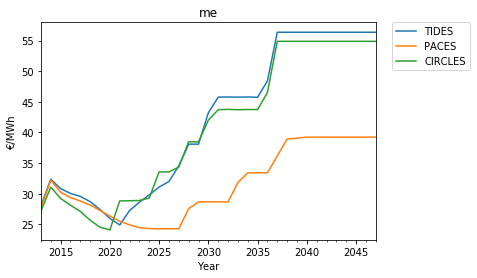

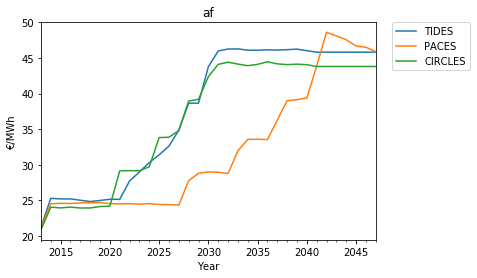

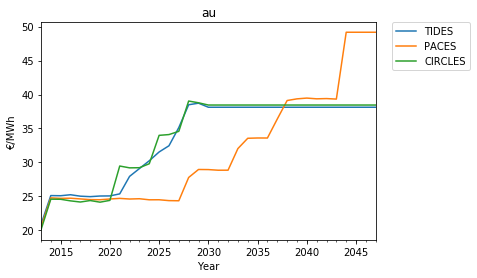

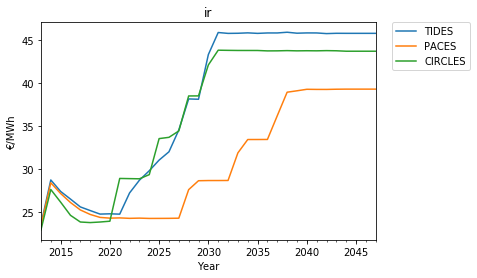

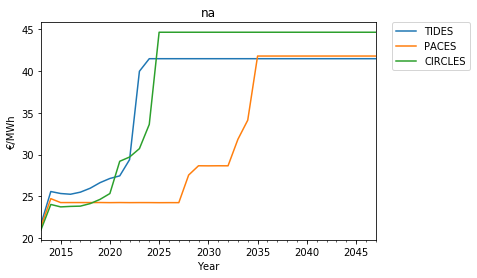

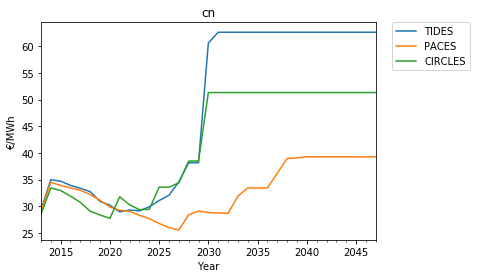

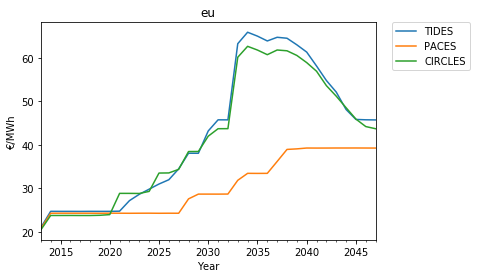

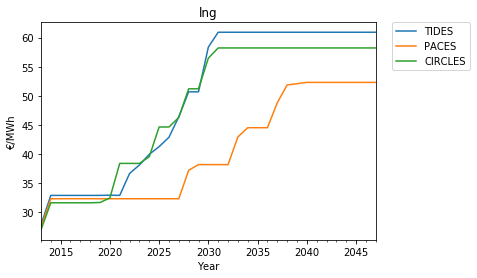

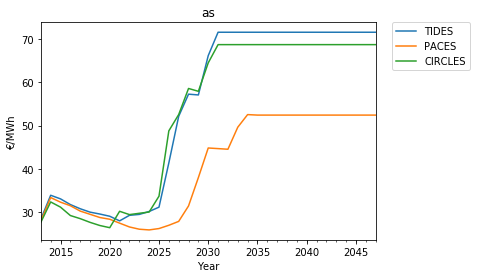

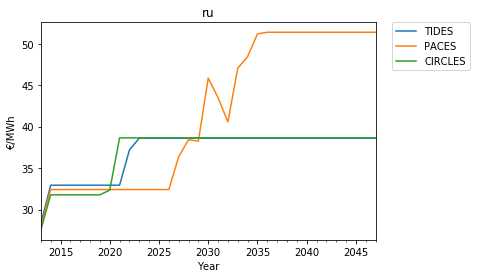

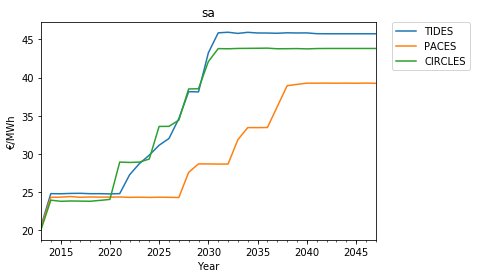

In [13]:
plt.subplots()
for market in init_market:
    for i in run_market:
        run_df = pd.DataFrame(run_market[i])
        run_df = run_df[run_df[3]==market]
        run_df.set_index(0, inplace=True)
        run_df.index = pd.to_datetime(run_df.index)
        run_df.index.name = 'month'
        run_df.rename(columns={1: 'price', 2: 'quantity'}, inplace=True)
        run_df = run_df['price'].resample('A').mean().plot(label=i, title=market)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.ylabel('€/MWh')
    plt.xlabel('Year')
    plt.show();

### saving data for later
To keep this file as clear as possible and for efficiency we visualize the results in a separate file. To transfer the model run data we use the Json library (and possibly excel).

In [14]:
today = datetime.date.today().strftime('%Y%m%d')
outputexcel = '.\exceloutput\%srun.xlsx' %today
writer = pd.ExcelWriter(outputexcel)

def write_to_excel():
    for i in run_market:
        run_df = pd.DataFrame(run_market[i])
        run_df.set_index(0, inplace=True)
        run_df.index = pd.to_datetime(run_df.index)
        run_df.index.name = 'month'
        run_df.rename(columns={1: 'price', 2: 'quantity'}, inplace=True)
        run_df.to_excel(writer, sheet_name=i)
write_to_excel()


In [15]:
# Writing JSON data
# market data
data = run_market
with open('marketdata.json', 'w') as f:
     json.dump(data, f)

In [16]:
# seller/reserve data
data = run_seller
with open('sellerdata.json', 'w') as f:
     json.dump(data, f)

In [17]:
# buyer data
data = run_buyer
with open('buyerdata.json', 'w') as f:
     json.dump(data, f)

In [18]:
#test_df = pd.DataFrame(run_reserve['CIRCLES']))
#test_dict = test_df.to_dict()
#test_df.to_json('reservedf.json',orient='split')
#test_df2 = pd.read_json('reservedf.json',orient='split')


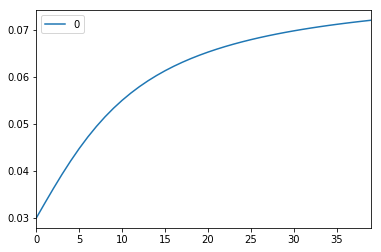

In [19]:
def func_1(x):
    demand = np.arctan(x/10)/(.5*np.pi)*.05+0.03
    return demand

pd.DataFrame([func_1(x) for x in range(40)]).plot()

# References

